In [1]:
#neccessary imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
import sympy as sy
import sympy.stats
from scipy.stats import norm
import pickle

1 8.184628029178183
2 5.939631707060538
3 3.9605382123177013
4 2.059984058741793
5 -0.9169992760209822
6 -3.0793327003320807


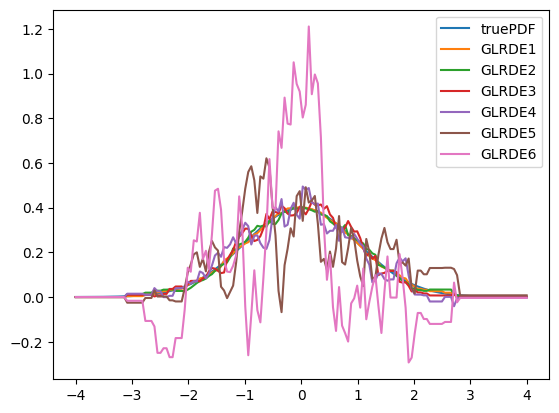

In [137]:
n = 2**9
nEval = 150
start, end = -4, 4
evalPoints = np.linspace(start, end, nEval)

def truePDF(x):
    return norm.pdf(x)
truePoints = truePDF(evalPoints)
fig, ax = plt.subplots()
plt.plot(evalPoints, truePoints, label = "truePDF")


initWeights = np.array([1, 0.5, 0.25, 0.125, 0.0625, 0.03125])
alpha = np.sqrt(np.sum(initWeights * initWeights))
weights = initWeights / alpha
dimension = len(initWeights)

sobolPoints = qp.Sobol(dimension).gen_samples(n)
transformedPoints = norm.ppf(sobolPoints)



def h(y):
    return np.sum(weights * y)


def GLRDEj(x, realizations, j):
    output = [0.0] * len(x)
    for i in range(len(x)):
        for k in range(len(realizations)):
            if h(realizations[k]) < x[i]:
                output[i] += -(1 / (len(realizations) * weights[j])) * realizations[k][j]
    return output

def getSquaredDiff(pointSet1, pointSet2):
    return np.sum((pointSet1 - pointSet2)**2)


GLRDEjPoints = np.array([[0.0] * nEval] * dimension)
for j in range(dimension):
    GLRDEjPoints[j] = GLRDEj(evalPoints, transformedPoints, j)
    plt.plot(evalPoints, GLRDEjPoints[j], label = f"GLRDE{j + 1}")
ax.legend()

for j in range(dimension):
    print(j+1, -np.log2(getSquaredDiff(GLRDEjPoints[j], truePoints)))


In [139]:
print(dimension)

6


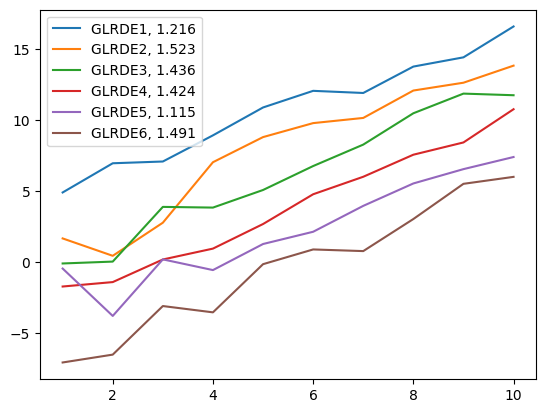

In [171]:
expStart, expStop = 1, 11
xvals = np.array(range(expStart, expStop))
yvals = np.array([[0.0] * dimension] * len(xvals))
nAvg = 150

for i in range(len(xvals)):
    exp = xvals[i]
    n = 2**exp
    GLRDEjPoints = np.array([[0.0] * nEval] * dimension)
    # for j in range(dimension):
    #     average = 0
    #     for k in range(nAvg):
    #         sobolPoints = qp.Sobol(dimension).gen_samples(n)
    #         transformedPoints = norm.ppf(sobolPoints)
    #         GLRDEjPoints[j] = GLRDEj(evalPoints, transformedPoints, j)
    #         average += (1 / nAvg) * getSquaredDiff(GLRDEjPoints[j], truePoints)
    #     yvals[i][j] = -np.log2(average)
    for k in range(nAvg):
        average = [0.0] * dimension
        sobolPoints = qp.Sobol(dimension).gen_samples(n)
        transformedPoints = norm.ppf(sobolPoints)
        for j in range(dimension):
            GLRDEjPoints[j] = GLRDEj(evalPoints, transformedPoints, j)
            error = getSquaredDiff(GLRDEjPoints[j], truePoints)
            average[j] += (1 / nAvg) * error
    yvals[i] = -np.log2(average)
fig, ax = plt.subplots()
for j in range(dimension):
    nu = stats.linregress(xvals, yvals[:, j]).slope
    plt.plot(xvals, yvals[:, j], label = f"GLRDE{j+1}, {round(nu, 3)}")
ax.legend()